In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from pytensor.tensor import TensorVariable

In [4]:
try:

    import pytensor.tensor as T
    #import aesara.tensor as T

except ImportError:

    import theano.tensor as T


def aesara_use_fast(x):
    """For each element in `x`, return `True` if the fast-RT expansion is more efficient
    than the slow-RT expansion.
    Args:
        x: RTs. (0, inf).
    """
    err = 1e-7  # I don't think this value matters much so long as it's small

    # determine number of terms needed for small-t expansion
    _a = 2 * T.sqrt(2 * np.pi * x) * err < 1
    _b = 2 + T.sqrt(-2 * x * T.log(2 * T.sqrt(2 * np.pi * x) * err))
    _c = T.sqrt(x) + 1
    _d = T.max(T.stack([_b, _c]), axis=0)
    ks = _a * _d + (1 - _a) * 2

    # determine number of terms needed for large-t expansion
    _a = np.pi * x * err < 1
    _b = 1.0 / (np.pi * T.sqrt(x))
    _c = T.sqrt(-2 * T.log(np.pi * x * err) / (np.pi ** 2 * x))
    _d = T.max(T.stack([_b, _c]), axis=0)
    kl = _a * _d + (1 - _a) * _b

    return ks < kl  # select the most accurate expansion for a fixed number of terms


def aesara_fnorm_fast(x, w):
    """Density function for lower-bound first-passage times with drift rate set to 0 and
    upper bound set to 1, calculated using the fast-RT expansion.
    Args:
        x: RTs. (0, inf).
        w: Normalized decision starting point. (0, 1).
    """
    bigk = 7  # number of terms to evaluate; TODO: this needs tuning eventually

    # calculated the dumb way
    # p1 = (w + 2 * -3) * T.exp(-T.power(w + 2 * -3, 2) / 2 / x)
    # p2 = (w + 2 * -2) * T.exp(-T.power(w + 2 * -2, 2) / 2 / x)
    # p3 = (w + 2 * -1) * T.exp(-T.power(w + 2 * -1, 2) / 2 / x)
    # p4 = (w + 2 * 0) * T.exp(-T.power(w + 2 * 0, 2) / 2 / x)
    # p5 = (w + 2 * 1) * T.exp(-T.power(w + 2 * 1, 2) / 2 / x)
    # p6 = (w + 2 * 2) * T.exp(-T.power(w + 2 * 2, 2) / 2 / x)
    # p7 = (w + 2 * 3) * T.exp(-T.power(w + 2 * 3, 2) / 2 / x)
    # p = (p1 + p2 + p3 + p4 + p5 + p6 + p7) / T.sqrt(2 * np.pi * T.power(x, 3))

    # calculated the better way
    # k = (T.arange(bigk) - T.floor(bigk / 2)).reshape((-1, 1))
    # y = w + 2 * k
    # r = -T.power(y, 2) / 2 / x
    # p = T.sum(y * T.exp(r), axis=0) / T.sqrt(2 * np.pi * T.power(x, 3))

    # calculated using the "log-sum-exp trick" to reduce under/overflows
    k = T.arange(bigk) - T.floor(bigk / 2)
    y = w + 2 * k.reshape((-1, 1))
    r = -T.power(y, 2) / 2 / x
    c = T.max(r, axis=0)
    p = T.exp(c + T.log(T.sum(y * T.exp(r - c), axis=0)))
    p = p / T.sqrt(2 * np.pi * T.power(x, 3))

    return p


def aesara_fnorm_slow(x, w):
    """Density function for lower-bound first-passage times with drift rate set to 0 and
    upper bound set to 1, calculated using the slow-RT expansion.
    Args:
        x: RTs. (0, inf).
        w: Normalized decision starting point. (0, 1).
    """
    bigk = 7  # number of terms to evaluate; TODO: this needs tuning eventually

    # calculated the dumb way
    # b = T.power(np.pi, 2) * x / 2
    # p1 = T.exp(-T.power(1, 2) * b) * T.sin(np.pi * w)
    # p2 = 2 * T.exp(-T.power(2, 2) * b) * T.sin(2 * np.pi * w)
    # p3 = 3 * T.exp(-T.power(3, 2) * b) * T.sin(3 * np.pi * w)
    # p4 = 4 * T.exp(-T.power(4, 2) * b) * T.sin(4 * np.pi * w)
    # p5 = 5 * T.exp(-T.power(5, 2) * b) * T.sin(5 * np.pi * w)
    # p6 = 6 * T.exp(-T.power(6, 2) * b) * T.sin(6 * np.pi * w)
    # p7 = 7 * T.exp(-T.power(7, 2) * b) * T.sin(7 * np.pi * w)
    # p = (p1 + p2 + p3 + p4 + p5 + p6 + p7) * np.pi
    # print(p)

    # calculated the better way
    k = T.arange(1, bigk + 1).reshape((-1, 1))
    y = k * T.sin(k * np.pi * w)
    r = -T.power(k, 2) * T.power(np.pi, 2) * x / 2
    p = T.sum(y * T.exp(r), axis=0) * np.pi
    # print(p)

    # calculated using the "log-sum-exp trick" to reduce under/overflows
    # k = T.arange(1, bigk + 1).reshape((-1, 1))
    # y = k * T.sin(k * np.pi * w)
    # r = -T.power(k, 2) * T.power(np.pi, 2) * x / 2
    # c = T.max(r, axis=0)
    # p = T.exp(c + T.log(T.sum(y * T.exp(r - c), axis=0))) * np.pi

    return p


def aesara_fnorm(x, w):
    """Density function for lower-bound first-passage times with drift rate set to 0 and
    upper bound set to 1, selecting the most efficient expansion per element in `x`.
    Args:
        x: RTs. (0, inf).
        w: Normalized decision starting point. (0, 1).
    """
    y = T.abs(x)
    f = aesara_fnorm_fast(y, w)
    s = aesara_fnorm_slow(y, w)
    u = aesara_use_fast(y)
    positive = x > 0
    return (f * u + s * (1 - u)) * positive


def aesara_pdf_sv(x, v, sv, a, z, t):
    """Probability density function with drift rates normally distributed over trials.
    Args:
        x: RTs. (-inf, inf) except 0. Negative values correspond to the lower bound.
        v: Mean drift rate. (-inf, inf).
        sv: Standard deviation of drift rate. [0, inf), 0 if fixed.
        a: Value of decision upper bound. (0, inf).
        z: Normalized decision starting point. (0, 1).
        t: Non-decision time. [0, inf)
    """
    flip = x > 0
    v = flip * -v + (1 - flip) * v  # transform v if x is upper-bound response
    z = flip * (1 - z) + (1 - flip) * z  # transform z if x is upper-bound response
    x = T.abs(x)  # abs_olute rts
    x = x - t  # remove nondecision time

    tt = x / T.power(a, 2)  # "normalize" RTs
    p = aesara_fnorm(tt, z)  # normalized densities

    return (
        T.exp(
            T.log(p)
            + ((a * z * sv) ** 2 - 2 * a * v * z - (v ** 2) * x)
            / (2 * (sv ** 2) * x + 2)
        )
        / T.sqrt((sv ** 2) * x + 1)
        / (a ** 2)
    )


def aesara_pdf_sv_sz(x, v, sv, a, z, sz, t):
    """Probability density function with normally distributed drift rate and uniformly
    distributed starting point.
    Args:
        x: RTs. (-inf, inf) except 0. Negative values correspond to the lower bound.
        v: Mean drift rate. (-inf, inf).
        sv: Standard deviation of drift rate. [0, inf), 0 if fixed.
        a: Value of decision upper bound. (0, inf).
        z: Normalized decision starting point. (0, 1).
        sz: Range of starting points [0, 1), 0 if fixed.
        t: Non-decision time. [0, inf)
    """
    # uses eq. 4.1.14 from Press et al., numerical recipes: the art of scientific
    # computing, 2007 for a more efficient 10-step approximation to the integral based
    # on simpson's rule
    n = 10
    h = sz / n
    z0 = z - sz / 2

    f = 17 * aesara_pdf_sv(x, v, sv, a, z0, t)
    f = f + 59 * aesara_pdf_sv(x, v, sv, a, z0 + h, t)
    f = f + 43 * aesara_pdf_sv(x, v, sv, a, z0 + 2 * h, t)
    f = f + 49 * aesara_pdf_sv(x, v, sv, a, z0 + 3 * h, t)

    f = f + 48 * aesara_pdf_sv(x, v, sv, a, z0 + 4 * h, t)
    f = f + 48 * aesara_pdf_sv(x, v, sv, a, z0 + 5 * h, t)
    f = f + 48 * aesara_pdf_sv(x, v, sv, a, z0 + 6 * h, t)

    f = f + 49 * aesara_pdf_sv(x, v, sv, a, z0 + h * (n - 3), t)
    f = f + 43 * aesara_pdf_sv(x, v, sv, a, z0 + h * (n - 2), t)
    f = f + 59 * aesara_pdf_sv(x, v, sv, a, z0 + h * (n - 1), t)
    f = f + 17 * aesara_pdf_sv(x, v, sv, a, z0 + h * n, t)

    return f / 48 / n


def aesara_pdf_sv_sz_st(x, v, sv, a, z, sz, t, st):
    """ "Probability density function with normally distributed drift rate, uniformly
    distributed starting point, and uniformly distributed nondecision time.
    Args:
        x: RTs. (-inf, inf) except 0. Negative values correspond to the lower bound.
        v: Mean drift rate. (-inf, inf).
        sv: Standard deviation of drift rate. [0, inf), 0 if fixed.
        a: Value of decision upper bound. (0, inf).
        z: Normalized decision starting point. (0, 1).
        sz: Range of starting points [0, 1), 0 if fixed.
        t: Nondecision time. [0, inf)
        st: Range of Nondecision points [0, 1), 0 if fixed.
    """
    # uses eq. 4.1.14 from Press et al., Numerical recipes: the art of scientific
    # computing, 2007 for a more efficient n-step approximation to the integral based
    # on simpson's rule when n is even and > 4.
    n = 10
    h = st / n
    t0 = t - st / 2

    f = 17 * aesara_pdf_sv_sz(x, v, sv, a, z, sz, t0)
    f = f + 59 * aesara_pdf_sv_sz(x, v, sv, a, z, sz, t0 + h)
    f = f + 43 * aesara_pdf_sv_sz(x, v, sv, a, z, sz, t0 + 2 * h)
    f = f + 49 * aesara_pdf_sv_sz(x, v, sv, a, z, sz, t0 + 3 * h)

    f = f + 48 * aesara_pdf_sv_sz(x, v, sv, a, z, sz, t0 + 4 * h)
    f = f + 48 * aesara_pdf_sv_sz(x, v, sv, a, z, sz, t0 + 5 * h)
    f = f + 48 * aesara_pdf_sv_sz(x, v, sv, a, z, sz, t0 + 6 * h)

    f = f + 49 * aesara_pdf_sv_sz(x, v, sv, a, z, sz, t0 + h * (n - 3))
    f = f + 43 * aesara_pdf_sv_sz(x, v, sv, a, z, sz, t0 + h * (n - 2))
    f = f + 59 * aesara_pdf_sv_sz(x, v, sv, a, z, sz, t0 + h * (n - 1))
    f = f + 17 * aesara_pdf_sv_sz(x, v, sv, a, z, sz, t0 + h * n)

    return f / 48 / n


def aesara_pdf_contaminant(x, l, r):
    """Probability density function of exponentially distributed RTs.
    Args:
        x: RTs. (-inf, inf) except 0. Negative values correspond to the lower bound.
        l: Shape parameter of the exponential distribution. (0, inf).
        r: Proportion of upper-bound contaminants. [0, 1].
    """
    # p = l * T.exp(-l * T.abs_(x))
    p = 1 / 20 # change to uniform distribution
    return r * p * (x > 0) + (1 - r) * p * (x < 0)


def aesara_pdf_sv_sz_st_con(x, v, sv, a, z, sz, t, st, q, l, r):
    """ "Probability density function with normally distributed drift rate, uniformly
    distributed starting point, uniformly distributed nondecision time, and
    exponentially distributed contaminants.
    Args:
        x: RTs. (-inf, inf) except 0. Negative values correspond to the lower bound.
        v: Mean drift rate. (-inf, inf).
        sv: Standard deviation of drift rate. [0, inf), 0 if fixed.
        a: Value of decision upper bound. (0, inf).
        z: Normalized decision starting point. (0, 1).
        sz: Range of starting points [0, 1), 0 if fixed.
        t: Nondecision time. [0, inf)
        st: Range of Nondecision points [0, 1), 0 if fixed.
        q: Proportion of contaminants. [0, 1].
        l: Shape parameter of the exponential distribution. (0, inf).
        r: Proportion of upper-bound contaminants. [0, 1].
    """
    p_rts = aesara_pdf_sv_sz_st(x, v, sv, a, z, sz, t, st)
    p_con = aesara_pdf_contaminant(x, l, r)
    return p_rts * (1 - q) + p_con * q


def aesara_wfpt_log_like(x, v, sv, a, z, sz, t, st, q, l, r):
    """Returns the log likelihood of the WFPT distribution with normally distributed
    drift rate, uniformly distributed starting point, uniformly distributed nondecision
    time, and exponentially distributed contaminants.
    Args:
        x: RTs. (-inf, inf) except 0. Negative values correspond to the lower bound.
        v: Mean drift rate. (-inf, inf).
        sv: Standard deviation of drift rate. [0, inf), 0 if fixed.
        a: Value of decision upper bound. (0, inf).
        z: Normalized decision starting point. (0, 1).
        sz: Range of starting points [0, 1), 0 if fixed.
        t: Nondecision time. [0, inf)
        st: Range of Nondecision points [0, 1), 0 if fixed.
        q: Proportion of contaminants. [0, 1].
        l: Shape parameter of the exponential distribution. (0, inf).
        r: Proportion of upper-bound contaminants. [0, 1].
    """
    # return element wise log likelihood
    return T.log(aesara_pdf_sv_sz_st_con(x, v, sv, a, z, sz, t, st, q, l, r))


def aesara_wfpt_rvs(v, sv, a, z, sz, t, st, q, l, r, size):
    """Generate random samples from the WFPT distribution with normally distributed
    drift rate, uniformly distributed starting point, uniformly distributed nondecision
    time, and exponentially distributed contaminants.
    Args:
        v: Mean drift rate. (-inf, inf).
        sv: Standard deviation of drift rate. [0, inf), 0 if fixed.
        a: Value of decision upper bound. (0, inf).
        z: Normalized decision starting point. (0, 1).
        sz: Range of starting points [0, 1), 0 if fixed.
        t: Nondecision time. [0, inf)
        st: Range of Nondecision points [0, 1), 0 if fixed.
        q: Proportion of contaminants. [0, 1].
        l: Shape parameter of the exponential distribution. (0, inf).
        r: Proportion of upper-bound contaminants. [0, 1].
        size: Number of samples to generate.
    """
    m = np.linspace(-12, 12, 48000)
    dx = m[1] - m[0]

    pdf = aesara_pdf_sv_sz_st_con(m, v, sv, a, z, sz, t, st, q, l, r)
    
    #import ipdb; ipdb.set_trace()
    cdf = T.extra_ops.cumsum(pdf) * dx
    cdf = cdf / cdf.max()
    u = np.random.random_sample(size)
    ix = T.extra_ops.searchsorted(cdf, u)
    xx = ix.eval()
    return m[xx]

In [8]:
z = 0.5 # bound
sz = 0.0
st = 0.0
q = 0.01
l = 0.5
r = 0.5
sv = 1

In [9]:
# generate data from two subjects
v1 = 1 # drift rate of subject 1
v2 = 2 # drift rate of subject 2
sv = 0.1
a = 0.8 # boundary
z = 0.5 # starting point
sz = 0.0
t = 0.0 # non decision time
st = 0.1
q = .02
l = 0.5
r = 0.8
size = 300

x1 = aesara_wfpt_rvs(v1, sv, a, z, sz, t, st, q, l, r, size)
x2 = aesara_wfpt_rvs(v2, sv, a, z, sz, t, st, q, l, r, size)

import pandas as pd
data = pd.DataFrame({'RT': np.hstack((x1, x2)), 'subj': np.hstack((np.ones(size), np.ones(size)*2))})
subjIdx, uniqueSubj = pd.factorize(data.subj)
coords = {
    'subj': uniqueSubj,
    'obs_id': np.arange(data.subj.size)
}

In [6]:
data

NameError: name 'data' is not defined

In [13]:
μh pm.Model(coords=coords) as hmodel: # initiate hierarchical model 
    
    subj = pm.ConstantData('subjIdx', subjIdx, dims='obs_id')
    
    μ_v = pm.Uniform(name="μ_v", lower=0.1, upper=5) # drift rate
    σ_v = pm.HalfNormal(name="σ_v", sigma=5)
    v = pm.Gamma(name='v', mu=μ_v, sigma=σ_v, dims="subj", initval=np.array([1, 1]))
    
    y = pm.CustomDist("data", v[subj], sv, a, z, sz, t, st, q, l, r, logp=aesara_wfpt_log_like,observed=data.RT)
    trace = pm.sample(nuts_sampler='numpyro',tune=500, draws=500, cores=2, target_accept=0.9)

SyntaxError: invalid syntax (2726074027.py, line 1)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

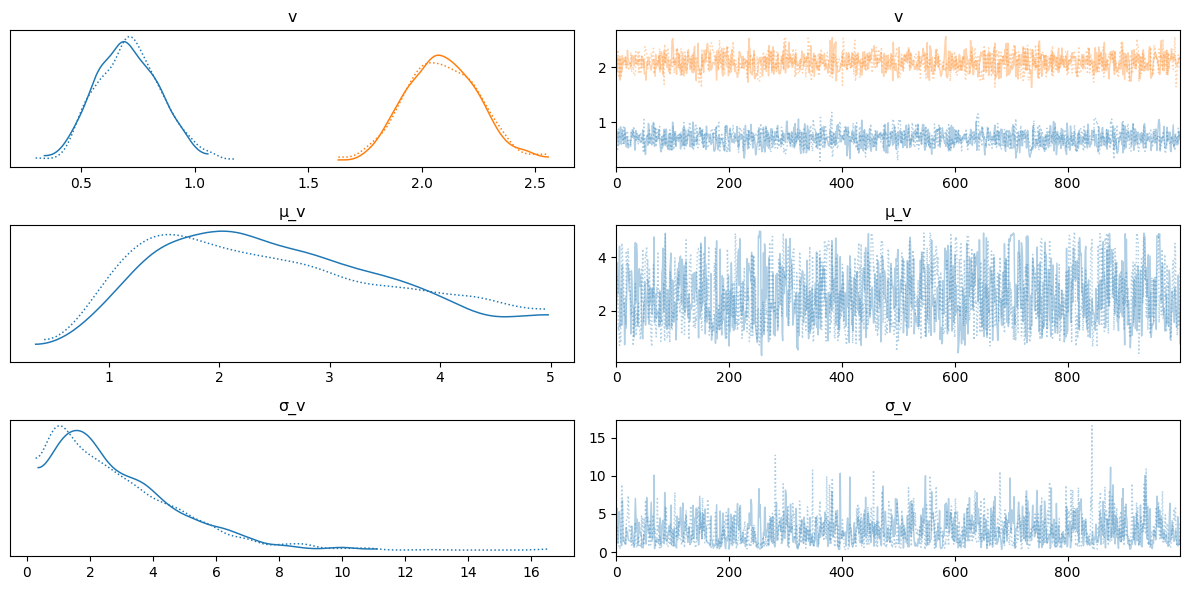

In [14]:
pm.plot_trace(trace)
plt.tight_layout()

In [ ]:
with pm.Model(coords=coords) as hierarchical:

    v = pm.Normal('v',mu=0,sigma=1)
    
    a = pm.TruncatedNormal('a',mu=0,sigma=1,lower=0.001)
    
    t = pm.HalfCauchy('t',beta=0.25)
    pm.CustomDist("data", v, sv, a, z, sz, t, st, q, l, r, \
                  logp=aesara_wfpt_log_like,observed=data.respRT)
    
with hierarchical:
    trace = pm.sample(tune=1000, draws=1000, cores=4, target_accept=0.99)
    
trace.to_netcdf("test2.nc")

In [ ]:
\mu